In [1]:
    
with open('lighthouse_flash_data.txt','r') as f:
    X = [] # x position
    I = [] # intensity
    lines = f.readlines()
    for line in lines:
        fmt_line = line.rstrip().split(' ')
        
        X.append(float(fmt_line[0]))
        I.append(float(fmt_line[1]))

print(X)

[5.450773594606204, 2.8830702582459624, 0.3887351549095234, -1.1086001431531707, 1.1093576215941827, -2.628564873336912, -1.7803127570795583, 70.52898470847045, -0.18206971212870038, -0.8658217893309939, 2.375160397172225, 0.48651618047968626, -2.211555411663329, 0.9728888035186474, -4.717332724143396, -1.2713725899366266, -18.8736973698282, -1.2933359427740854, -0.6610409162732975, 13.56432676140029]


In [2]:
import numpy as np
from typing import Callable
from multiprocessing import Pool
import matplotlib.pyplot as plt
from emcee.autocorr import integrated_time
from icecream import ic
from emcee.autocorr import AutocorrError
import random 
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

def metropolis_sampler(
    target_logPDF: Callable, x0: np.ndarray, n_samples: int, cov_Q: np.ndarray = None
):
    """
    Metropolis-Hastings sampler using a multivariate normal proposal
    distribution. Assumes target_logPDF is a callable function that takes a
    1D array of model parameters as input and returns the log of the target
    distribution at those parameters. This function generates samples by
    proposing new states from the multivariate normal distribution centered at
    the current state with a specified covariance matrix.

    Parameters
    ----------
    target_logPDF : Callable
        The log of the target distribution to sample from. This function must
        accept a 1D np.ndarray of parameters and return a float representing
        the log probability density of those parameters.
    x0 : np.ndarray
        The initial state of the chain. Shape should be (dim,), where dim is
        the dimensionality of the parameter space.
    n_samples : int
        The number of samples to generate.
    cov_Q : np.ndarray, optional
        The covariance matrix of the multivariate normal proposal distribution.
        If not provided, the identity matrix is used. Shape should be
        (dim, dim), where dim matches the dimensionality of x0.

    Returns
    -------
    np.ndarray, float
        - The samples from the chain. Shape will be (n_samples, dim), where dim
          is the dimensionality of the parameter space.
        - The acceptance rate as a float, representing the proportion of
        proposed samples that were accepted.

    """
    num_accept = 0
    chain = np.zeros((n_samples, len(x0)))
    if cov_Q is None:
        cov_Q = np.eye(len(x0))

    # Set the initial point.
    chain[0] = x0

    # Run the Metropolis-Hastings algorithm.
    for i in range(n_samples - 1):
        # Get the current point.
        x_current = chain[i]

        # Generate a proposed point.
        x_proposed = np.random.multivariate_normal(x_current, cov_Q)

        # Calculate log acceptance ratio.
        log_a = target_logPDF(x_proposed) - target_logPDF(x_current)

        # Accept / reject the proposed point.
        if np.log(np.random.uniform()) < log_a:
            x_new = x_proposed
            num_accept += 1
        else:
            x_new = x_current

        # Update the chain.
        chain[i + 1] = x_new

    # Calculate acceptance rate.
    acceptance_rate = num_accept / n_samples
    return chain, acceptance_rate


In [7]:
import numpy as np
from typing import Callable


def uniform_2d_prior(
    theta: np.ndarray, a: int = -100, b: int = 100, c: int = -100, d: int = 100
) -> float:
    """
    Uniform prior distribution for alpha and beta.
    Upper and lower bounds are a and b for alpha and c and d for beta.

    Parameters
    ----------
    theta : np.ndarray
        The parameter values to calculate the prior for.
    a : float
        Lower bound for alpha.
    b : float
        Upper bound for alpha.
    c : float
        Lower bound for beta.
    d : float
        Upper bound for beta.

    Returns
    -------
    float
        The prior probability of the parameter values.
    """
    alpha, beta = theta
    if (a <= alpha <= b) and (c <= beta <= d):
        return 1 / ((b - a)*(d - c))
    else:
        return 0


def cauchy(x: float, alpha: float, beta: float) -> float:
    """
    Likelihood function of the lighthouse problem.
    """
    return beta / (np.pi * (beta**2 + (x - alpha) ** 2))


def log_p(theta: np.ndarray, data: np.ndarray, prior: Callable) -> float:
    """
    Unnormalised log posterior of alpha and beta.

    Parameters
    ----------
    theta : np.ndarray
        The parameter values to calculate the log posterior for.
    data : np.ndarray
        The data to use in the likelihood function.
    prior : Callable
        The prior distribution of the parameters.

    Returns
    -------
    log_p : float
        The log posterior probability of the parameter values.
    """
    alpha, beta = theta
    log_likelihood = sum([np.log(cauchy(x, alpha, beta)) for x in data])
    log_p = log_likelihood + np.log(prior(theta))
    return log_p


In [8]:
from emcee.autocorr import AutocorrError

"""Tuning the covariance matrix"""
a,b = -np.max(X), np.max(X)
c,d = 0, 50
stds = [0.1, 0.5, 1, 2, 5, 10]
cov_Qs = [np.eye(2) * std for std in stds]
all_acceptances = []
all_max_taus = []
n_chains = range(10)
n_samples = 10000
for i in n_chains:
    # draw x0 from the prior
    alpha = np.random.uniform(a, b)
    beta = np.random.uniform(c, d)
    x0 = np.asarray([alpha,beta])
    acceptances = []
    max_taus = []
    for cov_Q in cov_Qs:
        samples, acceptance = metropolis_sampler(lambda theta: log_p(theta, X, uniform_2d_prior), x0, n_samples, cov_Q)
        acceptances.append(acceptance)
        try:
            max_tau = max(integrated_time(samples[:,0]), integrated_time(samples[:,1]))
            max_taus.append(max_tau)
        except AutocorrError:
            pass

    all_acceptances.append(acceptances)
    all_max_taus.append(max_taus)


/var/folders/dv/2dpvhcy95qq29g3502cyk9cc0000gn/T/ipykernel_30147/362440050.py:63: RuntimeWarning: divide by zero encountered in log
  log_likelihood = sum([np.log(cauchy(x, alpha, beta)) for x in data])
/var/folders/dv/2dpvhcy95qq29g3502cyk9cc0000gn/T/ipykernel_30147/362440050.py:63: RuntimeWarning: invalid value encountered in log
  log_likelihood = sum([np.log(cauchy(x, alpha, beta)) for x in data])


Acceptance rate with std = 0.1: 0.7331
Integrated autocorrelation time: [49.65520146]
Acceptance rate with std = 0.5: 0.4727
Integrated autocorrelation time: [14.50730332]
Acceptance rate with std = 1.0: 0.3468
Integrated autocorrelation time: [8.68665826]
Acceptance rate with std = 2.0: 0.2245
Integrated autocorrelation time: [9.39147013]
Acceptance rate with std = 5.0: 0.1172
Integrated autocorrelation time: [16.46494075]
Acceptance rate with std = 10.0: 0.0653
Integrated autocorrelation time: [28.96495201]
Acceptance rate with std = 0.1: 0.7252
Integrated autocorrelation time: [40.78661201]
Acceptance rate with std = 0.5: 0.4708
Integrated autocorrelation time: [11.5909177]
Acceptance rate with std = 1.0: 0.3488
Integrated autocorrelation time: [12.02042576]
Acceptance rate with std = 2.0: 0.2223
Integrated autocorrelation time: [11.76748591]
Acceptance rate with std = 5.0: 0.1181
Integrated autocorrelation time: [18.36254712]
Acceptance rate with std = 10.0: 0.0576
Integrated autoc

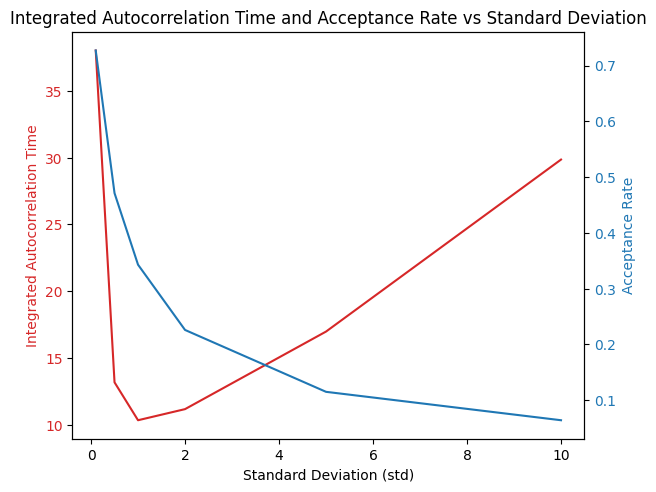

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

# Calculate the mean autocorrelation time and acceptance rate for each standard deviation across all chains
mean_max_taus = [np.mean([chain[i] for chain in all_max_taus]) for i in range(len(stds))]
mean_acceptances = [np.mean([chain[i] for chain in all_acceptances]) for i in range(len(stds))]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Standard Deviation (std)')
ax1.set_ylabel('Integrated Autocorrelation Time', color=color)
ax1.plot(stds, mean_max_taus, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Acceptance Rate', color=color)
ax2.plot(stds, mean_acceptances, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Integrated Autocorrelation Time and Acceptance Rate vs Standard Deviation')
plt.show()
plt.savefig('../report/figs/autocorrelation_time_vs_std.png', dpi=300)


In [6]:
x0 = np.asarray([0, 0])
n_samples = 100000
samples, acceptance = metropolis_sampler(lambda theta: log_p(theta, X, uniform_2d_prior), x0, n_samples, cov_Qs[0])

TypeError: 'int' object is not callable

In [ ]:
from emcee.autocorr import AutocorrError

"""Tuning the covariance matrix"""
a,b = -100, 100
c,d = 0, 50
stds = [0.1, 0.5, 1, 2, 5, 10]
cov_Qs = [np.eye(2) * std for std in stds]
all_acceptances = []
all_max_taus = []
n_chains = range(10)
for i in n_chains:
    # draw x0 from the prior
    alpha = np.random.uniform(a, b)
    beta = np.random.uniform(c, d)
    x0 = np.asarray([0,0])
    acceptances = []
    max_taus = []
    for cov_Q in cov_Qs:
        samples, acceptance = metropolis_sampler(lambda theta: log_p(theta, X, uniform_2d_prior), x0, n_samples, cov_Q)
        print(f"Acceptance rate with std = {cov_Q[0,0]}: {acceptance}")
        acceptances.append(acceptance)
        try:
            max_tau = max(integrated_time(samples[:,0]), integrated_time(samples[:,1]))
            max_taus.append(max_tau)
        except AutocorrError:
            pass
        print(f"Integrated autocorrelation time: {max_tau}")

    all_acceptances.append(acceptances)
    all_max_taus.append(max_taus)


In [ ]:

plt.figure()
for i in n_chains:
    plt.plot(stds, all_acceptances[i], label=f"Chain {i}")
    plt.plot(stds, all_max_taus[i], label=f"Chain {i}")
plt.xlabel("Standard deviation")
plt.ylabel("Acceptance rate")
plt.legend()
plt.savefig("acceptance_rate.png")

    



In [ ]:
x0 = np.asarray([-10, 10])
samples, acceptance = metropolis_sampler(lambda theta: log_p(theta, X, uniform_2d_prior),x0,n_samples, np.eye(2)*0.01)
ic(samples.shape, acceptance)
tau = integrated_time(samples[:,0]), integrated_time(samples[:,1])
ic(tau)


In [ ]:
# Run 10 chains with different starting points
n_chains = 10
n_samples = 100000
cov_Q = np.eye(2)
for i in n_chains:
    # draw x0 from the prior
    alpha = np.random.uniform(a, b)
    beta = np.random.uniform(c, d)
    x0 = np.asarray([alpha, beta])
    samples, acceptance = metropolis_sampler(lambda theta: log_p(theta, X, uniform_2d_prior), x0, n_samples, cov_Q)
    print(f"Acceptance rate: {acceptance}")
    tau = integrated_time(samples[:,0]), integrated_time(samples[:,1])
    print(f"Integrated autocorrelation time: {tau}")


In [ ]:
alpha_samples, beta_samples = samples[0][:, 0].flatten(), samples[0][:, 1].flatten()
# First, plot the hexbin heatmap as before
plt.hexbin(alpha_samples, beta_samples, gridsize=100, cmap='magma', bins='log')

# Overlay with a scatter plot of a subset of points for highlight
# (using a small alpha to make the scatter dots semi-transparent)
# plt.scatter(alpha_samples[::100], beta_samples[::100], color='blue', alpha=0.2)

plt.colorbar()
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.title("Joint distribution of alpha and beta with scatter overlay")
plt.show()


In [ ]:
def target_function(theta):
    return log_p(theta, X, uniform_2d_prior)
X0 = np.asarray([[0, 0], [0, 0], [0, 0], [0, 0]])
cov_Qs = np.asarray([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
n_samples = run_parallel_MH_chains(target_function, X0, 100000, cov_Qs, 4)